In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
covid = pd.read_csv(r'caso.csv', encoding = "utf-8")

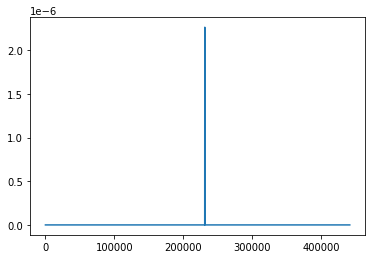

In [6]:
plt.plot(((covid['city'] == 'Recife'))/len(covid['city']))

In [41]:
(covid).head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-07-30,AP,NaN,state,36272,561,132,True,845731.0,16.0,4288.83416,0.0155
1,2020-07-29,AP,NaN,state,35973,559,131,False,845731.0,16.0,4253.48013,0.0155
2,2020-07-28,AP,NaN,state,35697,558,130,False,845731.0,16.0,4220.84564,0.0156
3,2020-07-27,AP,NaN,state,35364,556,129,False,845731.0,16.0,4181.47141,0.0157
4,2020-07-26,AP,NaN,state,35220,554,128,False,845731.0,16.0,4164.44472,0.0157


8316475
